In [150]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.ndimage import laplace # scipy has many submodules but we only need a single function for the Laplacian

L = 64   # size of simulation area
T = 16   # number of time steps
v = 0.1  # surface tension
l = 0.05 # non-linear KPZ term
max_starting_height = 10 # h(x,0) is in [0, max_starting_height)
seed_init = np.random.SeedSequence().entropy # create a constant seed for the initial interface so we can compare results
seed_random = np.random.SeedSequence().entropy # create a constant seed for the random term so we can compare results

# Noise term 
The noise term,

$\eta(\vec{x}, t)$,

has two conditions:
* $\langle\eta\rangle = 0$
* and no correlation in space or time between points.

Three easy functions work well:
* $\eta(\vec{x},t) = 0$
* A bounded choice where each point is -1 or 1
* A Gaussian distribution

We'll use the bounded choice because we can easily condition it so that the sum of the entire noise term is 0, to reflect the anticipated result for $t\to\inf$, but let's look at how we can create both.

Mass of bounded noise: 0.000
Mass of bounded noise: -13.198


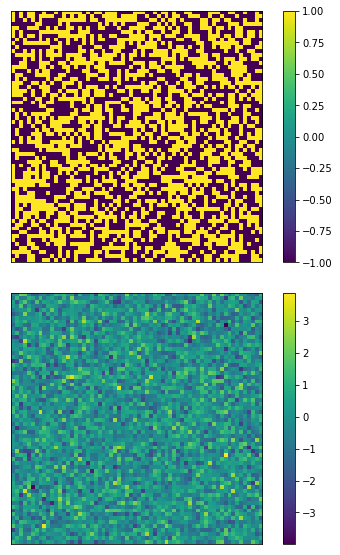

In [151]:
'''
    To create a bounded choice noise term we could randomly select -1 or 1 for each point,
    but to keep the entire mean 0 (as is expected for t->infinity over all x)
    and show some differences between the behaviors of EW and KPZ,
    we will create an array that is half -1 and half 1, and then shuffle it.
''' 

choice = -np.ones((L,L)) # all -1
choice[L//2:,:] = 1 # change half to 1
shuffler = np.random.default_rng(seed=seed_random) # create the shuffler
shuffler.shuffle(choice.flat) # shuffle the array
print(f'Mass of bounded noise: {np.sum(choice):.3f}')

# can't really do the same thing for the Gaussian so we'll let the mass be nonzero
gaussian = np.random.default_rng(seed=seed_random).normal(size=(L,L)) # Gaussian noise is easy to make in NumPy
print(f'Mass of bounded noise: {np.sum(gaussian):.3f}')

fig, ax = plt.subplots(2, figsize=(6,8))
im = ax[0].imshow(choice)
plt.colorbar(im, ax=ax[0])
im = ax[1].imshow(gaussian)
plt.colorbar(im, ax=ax[1])
fig.tight_layout()
for a in [0,1]:
    ax[a].set_xticks([])
    ax[a].set_yticks([])
plt.show()


# Edwards-Wilkinson
The EW equation is

$\frac{\partial h}{\partial t} = v\nabla^2 h + \eta(\vec{x},t)$,

where $v$ is the surface tension and drives relaxation of the surface.

First let's see the behavior of the EW equation when $\eta(\vec{x},t) = 0$.

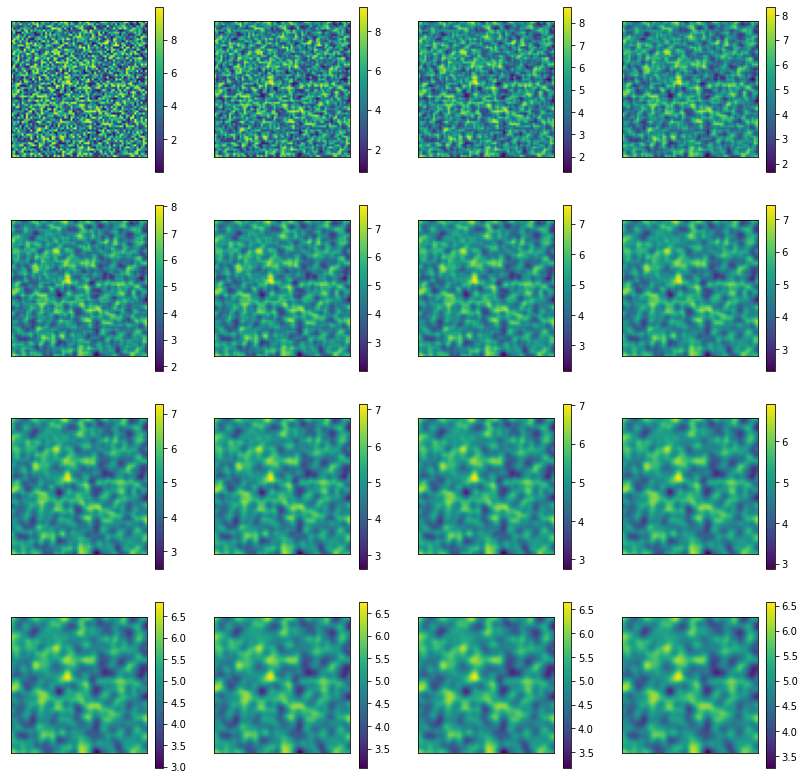

Starting volume: 20269.3
End volume: 20269.3


In [152]:
film = np.zeros((T,L,L)) # prepare the array for the film
film[0,:,:] = np.random.default_rng(seed=seed_init).uniform(0, max_starting_height, size=(L,L)) # set the initial layer to random, independent heights, uniformly distributed

for i in range(1,T):
    d_film = v*laplace(film[i-1,:,:]) # dh/dt only depends on the Laplacian
    film[i,:,:] = film[i-1,:,:] + d_film # h_t = h_t-1 + dh_t-1

# plot a selection of h(t) arrays to see how the film changes
fig, ax = plt.subplots(4,4,figsize=(14,14))
for i in range(4):
    for j in range(4):
        im = ax[i][j].imshow(film[i*4+j,:,:], origin='lower')
        plt.colorbar(im, ax=ax[i][j])
        ax[i][j].set_xticks([])
        ax[i][j].set_yticks([])
plt.show()

print(f'Starting volume: {np.sum(film[0,:,:]):.1f}')
print(f'End volume: {np.sum(film[-1,:,:]):.1f}')

The film relaxes quickly, starting grainy and noisy and transforming to have lower surface roughness. The final film is recognizable early in the process. The total mass of the interface doesn't change.

How does the film evolve when noise is included?

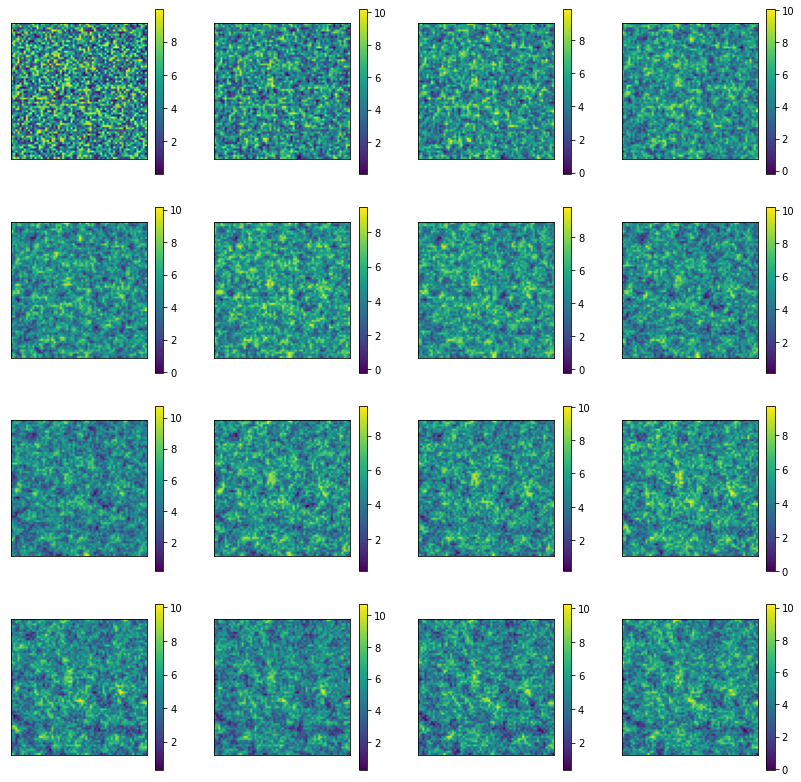

Starting volume: 20269.3
End volume: 20269.3
Noise volume: 0.000


In [153]:
film = np.zeros((T,L,L)) # prepare the array for the film
film[0,:,:] = np.random.default_rng(seed=seed_init).uniform(0, max_starting_height, size=(L,L)) # set the initial layer to random, independent heights, uniformly distributed

# create the bounded choice noise by shuffling an array of -1s and 1s
shuffler = np.random.default_rng(seed=seed_random)
noise = -np.ones((T,L,L))
noise[:,L//2:,:] = 1
shuffler.shuffle(noise[1:,:,:].flat)

for i in range(1,T):
    d_film = v*laplace(film[i-1,:,:]) + noise[i,:,:] # dh/dt now depends on the Laplacian and the noise
    film[i,:,:] = film[i-1,:,:] + d_film # h_t = h_t-1 + dh_t-1
    
fig, ax = plt.subplots(4,4,figsize=(14,14))
for i in range(4):
    for j in range(4):
        im = ax[i][j].imshow(film[i*4+j,:,:], origin='lower')
        plt.colorbar(im, ax=ax[i][j])
        ax[i][j].set_xticks([])
        ax[i][j].set_yticks([])
plt.show()

print(f'Starting volume: {np.sum(film[0,:,:]):.1f}')
print(f'End volume: {np.sum(film[-1,:,:]):.1f}')
print(f'Noise volume: {np.sum(noise[1:,:,:]):.3f}')

## EW results
The film relaxes more slowly than it did without noise. The film has some similarities with the previous film, but remains grainy throughout the growth. Again, the total mass of the interface does not change during growth.

# Kardar-Parisi-Zhang
The KPZ equation is similar to the EW equation,

$\frac{\partial h}{\partial t} = v\nabla^2 h + \lambda\left(\nabla h\right)^2 + \eta(\vec{x},t)$,

where $v$ remains the surface tension term and $\lambda$ is a new non-linear term. The non-linear term has a large effect and drives change in the mass of the interface.

First, let's see how the film changes without noise.

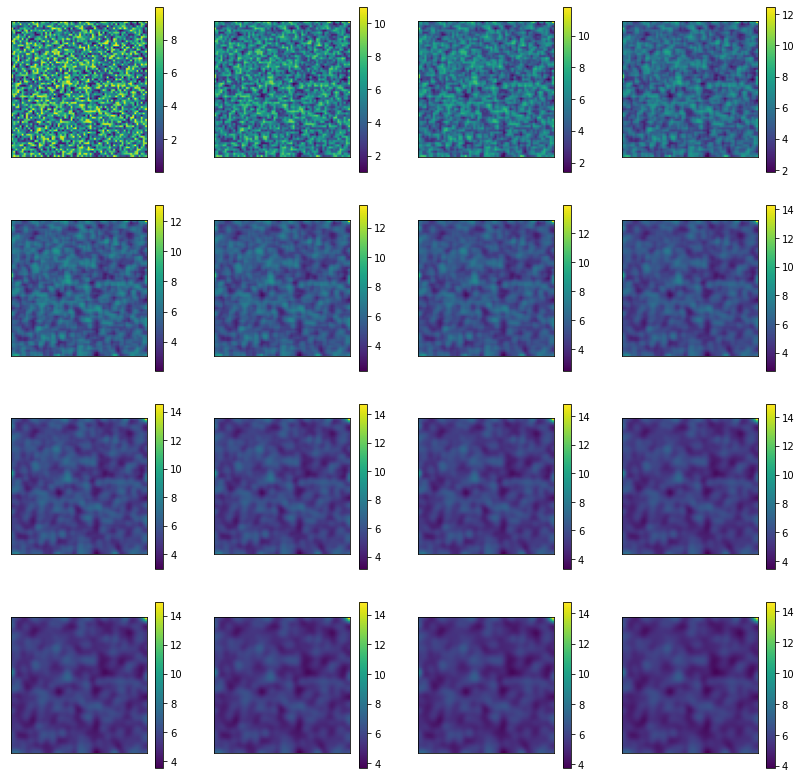

Starting volume: 20269.32793720979
End volume: 22219.525889999


In [154]:
film = np.zeros((T,L,L)) # prepare the array for the film
film[0,:,:] = np.random.default_rng(seed=seed_init).uniform(0, max_starting_height, size=(L,L)) # set the initial layer to random, independent heights, uniformly distributed

for i in range(1,T):
    l_film = laplace(film[i-1,:,:]) # calculate the Laplacian
    g_film = np.gradient(film[i-1,:,:]) # calculate the gradient
    g2_film = g_film[0]**2 + g_film[1]**2 # calculate the dot product of the gradient
    d_film = v*l_film + l/2*g2_film # dh/dt depends on the Laplacian and the dot product of the gradient
    film[i,:,:] = film[i-1,:,:] + d_film # h_t = h_t-1 + dh_t-1

fig, ax = plt.subplots(4,4,figsize=(14,14))
for i in range(4):
    for j in range(4):
        im = ax[i][j].imshow(film[i*4+j,:,:], origin='lower')
        plt.colorbar(im, ax=ax[i][j])
        ax[i][j].set_xticks([])
        ax[i][j].set_yticks([])
plt.show()

print(f'Starting volume: {np.sum(film[0,:,:])}')
print(f'End volume: {np.sum(film[-1,:,:])}')

The interface changes fairly quickly, showing some similarity to the results for the EW equation. The interface mass has grown, even without a noise term or explicit growth. 

Notice also that there are oddly high points that emerge along the edges during growth. This is a boundary effect, exposed by the gradient. To eliminate these, we would either need to expand the simulation area until that the interior isn't affected or impose some boundary conditions to address it. We will do this when working with ballistic simulation. 

How does a noise term affect the film?

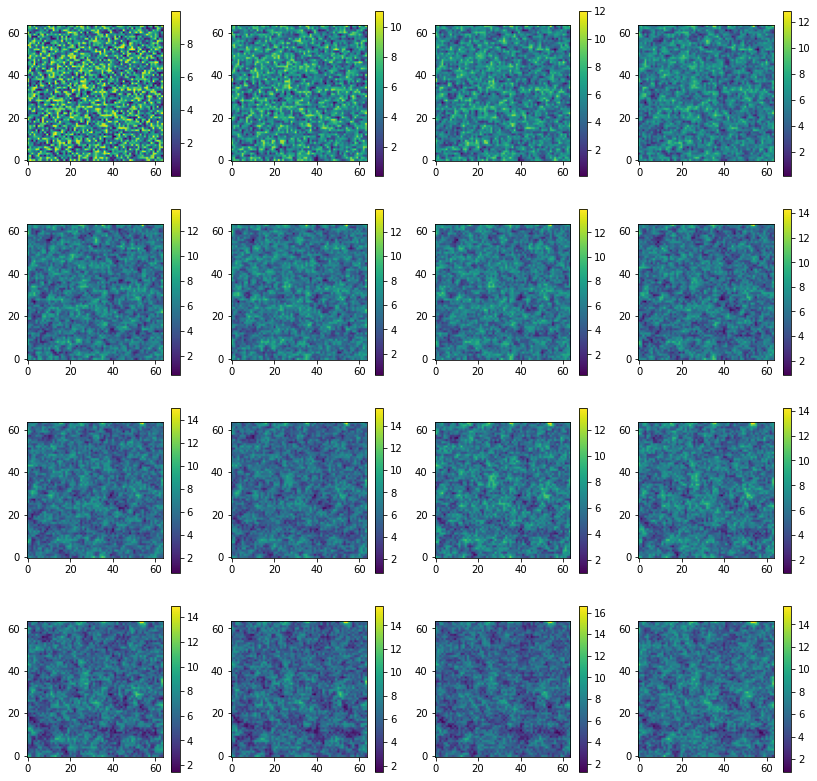

Starting volume: 20269.32793720979
End volume: 25022.32091383113
Force volume: 0.0


In [155]:
film = np.zeros((T,L,L)) # prepare the array for the film
film[0,:,:] = np.random.default_rng(seed=seed_init).uniform(0, max_starting_height, size=(L,L)) # set the initial layer to random, independent heights, uniformly distributed

# create the bounded choice noise by shuffling an array of -1s and 1s
shuffler = np.random.default_rng(seed=seed_random)
noise = -np.ones((T,L,L))
noise[:,L//2:,:] = 1
shuffler.shuffle(noise[1:,:,:].flat)

for i in range(1,T):
    l_film = laplace(film[i-1,:,:]) # calculate the Laplacian
    g_film = np.gradient(film[i-1,:,:]) # calculate the gradient
    g2_film = g_film[0]**2 + g_film[1]**2 # calculate the dot product of the gradient
    d_film = v*l_film + l/2*g2_film + noise[i,:,:] # dh/dt depends on the Laplacian, the dot product of the gradient, and the noise
    film[i,:,:] = film[i-1,:,:] + d_film # h_t = h_t-1 + dh_t-1
    

fig, ax = plt.subplots(4,4,figsize=(14,14))
for i in range(4):
    for j in range(4):
        im = ax[i][j].imshow(film[i*4+j,:,:], origin='lower')
        plt.colorbar(im, ax=ax[i][j])
plt.show()

print(f'Starting volume: {np.sum(film[0,:,:])}')
print(f'End volume: {np.sum(film[-1,:,:])}')
print(f'Force volume: {np.sum(force[1:,:,:])}')

## KPZ results
The interface is less stable than in any other case. While the film appears similar throughout, individual features arise and subside. The interface is clearly more rough than any other film and the interface mass has grown significantly; even though the noise itself has made no direct change to the mass, the changes to dh/dx and the nonlinear term have driven significant change.

The boundary effects may become even stronger, depending on how the noise term behaves.